# Create a 3D model of a Permo-Carboniferous Trough (PCT)

Based on two seismic sections from the NAGRA report [NAGRA NAB 14-17](https://www.nagra.ch/data/documents/database/dokumente/$default/Default%20Folder/Publikationen/NABs%202004%20-%202015/d_nab14-017.pdf), we extracted interface and orientation points for lithological units and faults.  

The lithological units comprise the permo-carboniferous filling (divided in three stages based on the report results), Mesozoic, Tertiary, and Quaternary strata, as well as the Palaeozoic crystalline basement rocks.

In [35]:
# These two lines are necessary only if GemPy is not installed via pip
import sys, os
sys.path.append(r'../../gempy/')
#sys.path.append(r'/Users/nijan/Documents/git/gempy/')

# Importing GemPy
import gempy as gp

# Importing auxilary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For embedding matplotlib figures
#%matplotlib qt5
%matplotlib inline

In [2]:
# Import improved plotting features
from gempy.plot import visualization_2d as vv
from gempy.plot import vista

In [15]:
## progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Initialize the model
We start with modelling the trough by generating a gempy model object. This will use interface points and orientations, which we previously stored in a `.csv` file.

In [3]:
np.random.seed(333)
# Import data
# Create a model instance
geo_model = gp.create_model('PCT_model')

# Initialize the model, set dimension and load interface and orientation data
gp.init_data(geo_model, [0, 28000., 0, 14000., -6500, 1000.], [100, 50, 60],
            path_i = '../data/leu2008/line82_interfaces_MC.csv',
            path_o = '../data/leu2008/line82_foliations_MC.csv');
geo_model.set_topography(source='random', d_z=np.array([300,1000]));

Active grids: ['regular']
Active grids: ['regular' 'topography']


/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/plot/plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


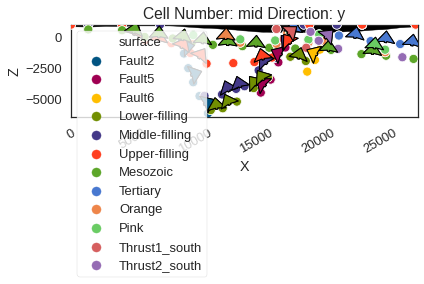

In [4]:
gp.plot_2d(geo_model, show_data=True, show_topography=True)

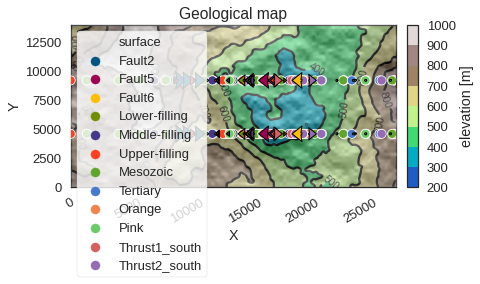

In [5]:
gp.plot_2d(geo_model, show_data=False, show_topography=True, show_values=False, section_names=['topography'],
          show_results=False)
plt.show()

## Setting up a Figure for a Cross section

In [14]:
%matplotlib qt5
import pyvista as pv
pv.set_plot_theme("document")

p2d = vv.Plot2D(geo_model)
p2d.create_figure((13,6));

### Add a model section
after creating the Figure object, we can add a cross section from our model

In [15]:
# A section along the x axis
ax = p2d.add_section(cell_number=5, direction='y')

### load a cross section image
with the figure above active, we can add a figure of a cross section to it

In [7]:
# read image
img = mpimg.imread('../imgs/line82_nf-10.png')
# Plotting it in place
ax.imshow(img, origin='upper', alpha=.7, extent = (500, 28500, -6500, 1000));

In [8]:
p2d.plot_data(ax)

# Adding information to the model
## Surfaces

In [11]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Fault2,Default series,1,#015482,1
1,Fault5,Default series,2,#9f0052,2
2,Fault6,Default series,3,#ffbe00,3
3,Lower-filling,Default series,4,#728f02,4
4,Middle-filling,Default series,5,#443988,5
5,Upper-filling,Default series,6,#ff3f20,6
6,Mesozoic,Default series,7,#5DA629,7
7,Tertiary,Default series,8,#4878d0,8
8,Orange,Default series,9,#ee854a,9
9,Pink,Default series,10,#6acc64,10


## Characteristics  
Main features of the model is the asymetric graben system, with the major fault (denoted with **A**), and the graben fill, which is not present beyond the graben shoulders. This, as well as the stop of major faults beneath the mesozoic units (blue units) are important considerations for the modelling process.  
These could be caught, for instance, in likelihood functions if we model the PCT as a Bayesian inference problem.

In [6]:
# Assign formations to series
gp.map_series_to_surfaces(geo_model,
                         {"Thrust1_series": 'Thrust1_south',
                          "Thrust2_series": 'Thrust2_south',
                          "Fault2_series": 'Fault2',
                          "Fault5_series": 'Fault5',
                          "Fault6_series": 'Fault6',
                         "Post_tectonic_series": ('Tertiary', 'Orange', 
                                                  'Pink'),
                          "Detachement": 'Mesozoic',
                         "Syn_tectonic_series2": 'Upper-filling',
                         "Syn_tectonic_series1": 'Middle-filling',
                         "Pre_tectonic_series": 'Lower-filling'},
                         remove_unused_series=True)
geo_model.surfaces

,surface,series,order_surfaces,color,id
10,Thrust1_south,Thrust1_series,1,#d65f5f,1
11,Thrust2_south,Thrust2_series,1,#956cb4,2
0,Fault2,Fault2_series,1,#015482,3
1,Fault5,Fault5_series,1,#9f0052,4
2,Fault6,Fault6_series,1,#ffbe00,5
7,Tertiary,Post_tectonic_series,1,#4878d0,6
8,Orange,Post_tectonic_series,2,#ee854a,7
9,Pink,Post_tectonic_series,3,#6acc64,8
6,Mesozoic,Detachement,1,#5DA629,9
5,Upper-filling,Syn_tectonic_series2,1,#ff3f20,10


In [7]:
# Set Faults
geo_model.set_is_fault(['Thrust1_series', 'Thrust2_series',
                        'Fault2_series', 'Fault5_series', 'Fault6_series'],
                      change_color=False);
#geo_model.set_is_finite_fault(series_fault=['Fault1_series', 'Fault7_series', 'Fault6_series', 
#                                            'Fault5_series', 'Fault3_series', 'Fault4_series'],
#                              toggle=True)

In [8]:
geo_model.set_bottom_relation(series=['Post_tectonic_series', 
                                      'Pre_tectonic_series',
                                      'Syn_tectonic_series1',
                                      'Syn_tectonic_series2'], bottom_relation='Onlap') #,

,order_series,BottomRelation,isActive,isFault,isFinite
Thrust1_series,1,Fault,True,True,False
Thrust2_series,2,Fault,True,True,False
Fault2_series,3,Fault,True,True,False
Fault5_series,4,Fault,True,True,False
Fault6_series,5,Fault,True,True,False
Post_tectonic_series,6,Onlap,True,False,False
Detachement,7,Erosion,True,False,False
Syn_tectonic_series2,8,Onlap,True,False,False
Syn_tectonic_series1,9,Onlap,True,False,False
Pre_tectonic_series,10,Onlap,True,False,False


In [9]:
# table of fault relations
geo_model.faults.faults_relations_df

,Thrust1_series,Thrust2_series,Fault2_series,Fault5_series,Fault6_series,Post_tectonic_series,Detachement,Syn_tectonic_series2,Syn_tectonic_series1,Pre_tectonic_series,Basement
Thrust1_series,False,False,False,False,False,True,True,True,True,True,True
Thrust2_series,False,False,False,False,False,True,True,True,True,True,True
Fault2_series,False,False,False,False,False,True,True,True,True,True,True
Fault5_series,False,False,False,False,False,True,True,True,True,True,True
Fault6_series,False,False,False,False,False,True,True,True,True,True,True
Post_tectonic_series,False,False,False,False,False,False,False,False,False,False,False
Detachement,False,False,False,False,False,False,False,False,False,False,False
Syn_tectonic_series2,False,False,False,False,False,False,False,False,False,False,False
Syn_tectonic_series1,False,False,False,False,False,False,False,False,False,False,False
Pre_tectonic_series,False,False,False,False,False,False,False,False,False,False,False


In [10]:
fr = np.array([[False, True, False, False, False, True, False, False, False, False, False],
               [False, False, False, False, False, True, False, False, False, False, False],
               [False, False, False, False, False, False, True, True, True, True, True],
               [False, False, False, False, False, False, True, True, True, True, True],
               [False, False, False, False, False, False, True, True, True, True, True],
               [False, False, False, False, False, False, False, False, False, False, False],
               [False, False, False, False, False, False, False, False, False, False, False],
               [False, False, False, False, False, False, False, False, False, False, False],
               [False, False, False, False, False, False, False, False, False, False, False],
               [False, False, False, False, False, False, False, False, False, False, False],
               [False, False, False, False, False, False, False, False, False, False, False]])
geo_model.set_fault_relation(fr)

,Thrust1_series,Thrust2_series,Fault2_series,Fault5_series,Fault6_series,Post_tectonic_series,Detachement,Syn_tectonic_series2,Syn_tectonic_series1,Pre_tectonic_series,Basement
Thrust1_series,False,True,False,False,False,True,False,False,False,False,False
Thrust2_series,False,False,False,False,False,True,False,False,False,False,False
Fault2_series,False,False,False,False,False,False,True,True,True,True,True
Fault5_series,False,False,False,False,False,False,True,True,True,True,True
Fault6_series,False,False,False,False,False,False,True,True,True,True,True
Post_tectonic_series,False,False,False,False,False,False,False,False,False,False,False
Detachement,False,False,False,False,False,False,False,False,False,False,False
Syn_tectonic_series2,False,False,False,False,False,False,False,False,False,False,False
Syn_tectonic_series1,False,False,False,False,False,False,False,False,False,False,False
Pre_tectonic_series,False,False,False,False,False,False,False,False,False,False,False


## Creating the model
Now that we set the parameters and fault relations, it is time to start the modeling process:

In [11]:
# Set the interpolator function
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[]);

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                             values
range                                      32190.8
$C_o$                                  2.46726e+07
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [12]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=True)

/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/core/solution.py:315: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:8
  '; Surface Number:' + str(s_n))
/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/core/solution.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array([values[0][:, l0: l1], values[4][:, l0: l1].astype(float)])


When plotting the scalar field, we actually see what the gradients (the orientation triangles) look like for the different units / faults. 

In [18]:
# Plot solution in 2D
#p2d.plot_contacts(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5, alpha=1.)
p2d.plot_topography(ax)

# Plot solution in 3D
#p3d.plot_surfaces()
#p3d.plot_structured_grid()

/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/plot/plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


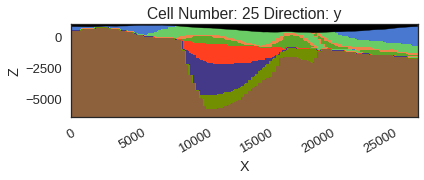

In [19]:
gp.plot_2d(geo_model, cell_number=25, show_data=False, show_topography=True,
          show_lith=True, show_results=True, show_boundaries=False)

## MC Variation

In [13]:
depth_zero = geo_model.surface_points.df['Z'].copy()
depth = depth_zero.copy()

In [14]:
graben_bot = list(geo_model.surface_points.df.query("surface=='Lower-filling'"))

In [16]:
# mask_surfpoints = geo_model.surface_points.df.series.isin(faults)
np.random.seed(420)
lith_blocks = np.array([])
depth = geo_model.surface_points.df['Z'].copy()
graben = list(geo_model.surface_points.df.query("surface=='Lower-filling'").index)
n_points = len(graben)
n_iterations = 100

geo_model._grid
#for i in range(n_iterations):
for i in log_progress(range(n_iterations), name='Models'):
    variation = np.random.normal(0, 100)
    Z = depth[graben] + np.random.normal(variation, 70, size=n_points)
    geo_model.modify_surface_points(graben, Z=Z)
    gp.compute_model(geo_model)
    lith_blocks = np.append(lith_blocks, geo_model.solutions.lith_block)

lith_blocks = lith_blocks.reshape(n_iterations, -1)

/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/core/solution.py:315: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:8
  '; Surface Number:' + str(s_n))
/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/core/solution.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array([values[0][:, l0: l1], values[4][:, l0: l1].astype(float)])


In [136]:
units = geo_model.surfaces.df[['surface', 'id']]
params = {'por': np.array([1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 0.1, 0.05, 0.05, 0.01, 0.1, 0.01, 0.05, 0.01]).T,
         'perm': np.array([1e-16, 1e-16, 1e-16, 1e-16, 1e-16, 1e-14, 1e-14, 1e-15, 1e-17, 1e-14, 1e-16, 1e-15, 1e-16]),
         'lz':   np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.3, 1.93, 2.9, 4.64, 3.03, 1.93, 3.21, 3.1])}

In [137]:
units = units.join(pd.DataFrame(params, index=units.index))

In [138]:
units.shape

(13, 5)

In [139]:
air = {'surface': 'air',
       'id': units.shape[0]+1,
      'por': 1e-10,
      'perm': 1e-22,
      'lz': 100}

In [140]:
units = units.append(air, ignore_index=True)

In [141]:
units

,surface,id,por,perm,lz
0,Thrust1_south,1,1.000000e-10,1.000000e-16,2.50
1,Thrust2_south,2,1.000000e-10,1.000000e-16,2.50
2,Fault2,3,1.000000e-10,1.000000e-16,2.50
3,Fault5,4,1.000000e-10,1.000000e-16,2.50
4,Fault6,5,1.000000e-10,1.000000e-16,2.50
5,Tertiary,6,1.000000e-01,1.000000e-14,2.30
6,Pink,7,5.000000e-02,1.000000e-14,1.93
7,Orange,8,5.000000e-02,1.000000e-15,2.90
8,Mesozoic,9,1.000000e-02,1.000000e-17,4.64
9,Upper-filling,10,1.000000e-01,1.000000e-14,3.03


In [195]:
import itertools as it
def export_shemat_suite_input_file(geo_model, lithology_block, units: pd.DataFrame=None, bcs_file: str=None, 
                                   path: str=None, filename: str='geo_model_SHEMAT_input_erode'):
    """
    Method to export a 3D geological model as SHEMAT-Suite input-file for a conductive HT-simulation. 

    Args:
        path (str): Filepath for the exported input file (default './')
        filename (str): name of exported input file (default 'geo_model_SHEMAT_input')
    """
    # get model dimensions
    nx, ny, nz = geo_model.grid.regular_grid.resolution
    xmin, xmax, ymin, ymax, zmin, zmax = geo_model.solutions.grid.regular_grid.extent
    
    delx = (xmax - xmin)/nx
    dely = (ymax - ymin)/ny
    delz = (zmax - zmin)/nz
    
    # get unit IDs and restructure them
    #ids = np.round(geo_model.solutions.lith_block)
    #ids = ids.astype(int)
    ids = np.round(lithology_block)
    ids = ids.astype(int)
    
    liths = ids.reshape((nx, ny, nz))
    liths = liths.flatten('F')

    # group litho in space-saving way
    sequence = [len(list(group)) for key, group in it.groupby(liths)]
    unit_id = [key for key, group in it.groupby(liths)]
    combined = ["%s*%s" % (pair) for pair in zip(sequence,unit_id)]

    combined_string = " ".join(combined)
    
    # bcs
    with open(bcs_file, 'r') as file:
        bc_vals = file.read()
        file.seek(0)
        lines = len(file.readlines())
    
    unitstring = ""
    try:
        for index, rows in units.iterrows():
            unitstring += f"{rows['por']}    1.d0  1.d0  {rows['perm']}	 1.e-10  1.d0  1.d0  {rows['lz']}	0.  2077074.  10  2e-3	!{rows['surface']} \n" 	
    except:
        print("No units table found, filling in default values for petrophysical properties.")
        # get number of units and set units string
        units = geo_model.surfaces.df[['surface', 'id']]
        for index, rows in units.iterrows():
            unitstring += f"0.01d0    1.d0  1.d0  1.e-14	 1.e-10  1.d0  1.d0  3.74	0.  2077074.  10  2e-3	!{rows['surface']} \n" 	
        
    # input file as f-string
    fstring = f"""!==========>>>>> INFO
# Title
{filename}

# linfo
1 2 1 1

# runmode
1

# timestep control
0
1           1           0           0

# tunit
1
 
# time periods, records=1
0      60000000    200      lin
           
# output times, records=10
1
6000000
12000000
18000000
24000000
30000000
36000000
42000000
48000000
54000000
    
# file output: hdf vtk

# active temp

# PROPS=bas

# USER=none


# grid
{nx} {ny} {nz}

# delx
{nx}*{delx}

# dely
{ny}*{dely}

# delz
{nz}*{delz}

!==========>>>>> NONLINEAR SOLVER
# nlsolve
50 0

!==========>>>>> FLOW
# lsolvef (linear solver control)
1.d-12 64 500
# nliterf (nonlinear iteration control)
1.0d-10 1.0

!==========>>>>> TEMPERATURE
# lsolvet (linear solver control)
1.d-12 64 500
# nlitert (nonlinear iteration control)
1.0d-10 1.0

!==========>>>>> INITIAL VALUES
# temp init
{nx*ny*nz}*15.0d0  

# head init
{nx*ny*nz}*7500

!==========>>>>> UNIT DESCRIPTION
!!
# units
{unitstring}

!==========>>>>>   define boundary properties
# temp bcd, simple=top, value=init

# temp bcn, simple=base, error=ignore
{nx*ny}*0.08

# head bcd, records={lines}
{bc_vals}

# uindex
{combined_string}"""

    if not path:
        path = './'
    if not os.path.exists(path):
        os.makedirs(path)

    f = open(path+filename, 'w+')
    
    f.write(fstring)
    f.close()
    
    print(f"Successfully exported geological model {filename} as SHEMAT-Suite input to "+path)        

In [143]:
model_shape = geo_model._grid.regular_grid.mask_topo.shape
topo_mask = geo_model._grid.regular_grid.mask_topo

In [144]:
ids = np.round(geo_model.solutions.lith_block)
ids = ids.astype(int)

liths = ids.reshape(geo_model._grid.regular_grid.mask_topo.shape)

In [145]:
lith_blocks_topo = np.array([])
for i in lith_blocks:
    ids = np.round(i)
    ids = ids.astype(int)
    
    liths = ids.reshape(model_shape)
    liths[topo_mask] = np.unique(liths)[-1]+1
    lith_blocks_topo = np.append(lith_blocks_topo, liths)
lith_blocks_topo = lith_blocks_topo.reshape(n_iterations, -1)

In [165]:
with open('../data/SHEMAT-Model_DTM', 'r') as file:
    data = file.read()

In [175]:
ijk_dtm = pd.read_csv('../data/SHEMAT-Model_DTM', header=None)

In [176]:
ijk_dtm

,0,1,2,3,4
0,1,1,60,7330.446,0
1,1,2,60,7324.368,0
2,1,3,59,7311.065,0
3,1,3,60,7311.065,0
4,1,4,59,7310.738,0
...,...,...,...,...,...
13647,100,49,59,7131.986,0
13648,100,49,60,7131.986,0
13649,100,50,58,7111.295,0
13650,100,50,59,7111.295,0


In [72]:
liths[topo_mask] = np.unique(liths)[-1]+1

In [77]:
liths.shape

(100, 50, 60)

In [83]:
100*50*60

300000

In [196]:
shemade = ""
for c in range(100):
    model = lith_blocks_topo[c,:]
    model_name = f"PCT_MC_{c}"
    export_shemat_suite_input_file(geo_model, lithology_block=model, units=units, 
                                   bcs_file='../data/SHEMAT-Model_DTM',
                                   path='../models/20210219_MC_ensemble/',
                                  filename=model_name)
    shemade += model_name + " \n"
with open("../models/20210219_MC_ensemble/shemade.job", 'w') as jobfile:
    jobfile.write(shemade)


Successfully exported geological model PCT_MC_0 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_1 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_2 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_3 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_4 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_5 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_6 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_7 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_8 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_9 as SHEM

Successfully exported geological model PCT_MC_79 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_80 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_81 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_82 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_83 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_84 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_85 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_86 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_87 as SHEMAT-Suite input to ../models/20210219_MC_ensemble/
Successfully exported geological model PCT_MC_

ValueError: Expected 1D or 2D array, got 0D array instead

In [198]:
with open("../models/20210219_MC_ensemble/shemade.job", 'w') as jobfile:
    jobfile.write(shemade)


## Export head as bcd from topography

In [78]:
ijk = np.where(liths[:,:,:]==14)

In [82]:
np.stack([ijk[0],ijk[1],ijk[2]], axis=1)

(13652, 3)

In [122]:
zs = geo_model._grid.topography.values[:,2]

In [123]:
zs = zs.reshape((100, 50), order='C')

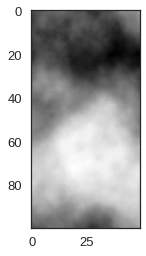

In [124]:
plt.imshow(zs)

In [126]:
ijk = np.where(liths[:,:,:]==14)

s=np.stack([ijk[0],ijk[1],ijk[2]], axis=1)
s1 = s.copy()

s2 = np.append(s, s1, axis=0)

new_array = [tuple(row) for row in s2]
s3 = np.unique(new_array, axis=0)

height = np.zeros(len(s3))

for i in range(len(s3)):
    indices = s3[i,:2]
    height[i] = zs[indices[0], indices[1]]
    
hresh = height.reshape(-1,1)
ijkh = np.append(s3, hresh, axis=1)
direction = np.zeros_like(hresh)

ijkh[:,:3] = ijkh[:,:3] + 1
ijkh[:,3] = ijkh[:,3] + 6500
ijkh_d = np.append(ijkh, direction, axis=1)

In [129]:
np.savetxt('../data/SHEMAT-Model_DTM', ijkh_d, fmt='%d, %d, %d, %.3f, %d')

## Gravity

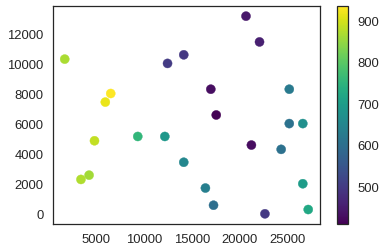

In [88]:
# distribute stations
import random
random.seed(90)
station_indices = random.sample(range(0, 4999), 25)
station_coordinates = geo_model._grid.topography.values[station_indices, :]

cs = plt.scatter(station_coordinates[:,0], station_coordinates[:,1], c=station_coordinates[:,2], cmap='viridis')
plt.colorbar(cs)

In [90]:
from gempy.assets.geophysics import GravityPreprocessing
geo_model.set_centered_grid(station_coordinates,  resolution = [10, 10, 15], radius=6000)
g = GravityPreprocessing(geo_model.grid.centered_grid)
tz = g.set_tz_kernel()

Active grids: ['regular' 'topography' 'centered']


In [91]:
k_l, k_r, k_c = geo_model.grid.centered_grid.kernel_dxyz_left, geo_model.grid.centered_grid.kernel_dxyz_right, geo_model.grid.centered_grid.kernel_centers

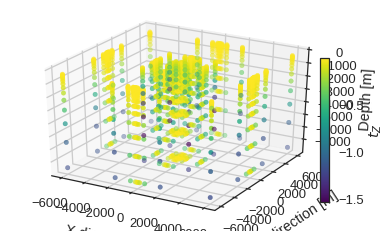

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cs = ax.scatter(k_c[:, 0], k_c[:, 1], k_c[:, 2], c=tz, cmap='viridis')

ax.set_xlabel('\nX direction [m]', linespacing=3)
ax.set_ylabel('\nY direction [m]', linespacing=3)
ax.set_zlabel('\nDepth [m]', linespacing=3)
cbaxes = fig.add_axes([0.85, 0.2, 0.02, 0.5]) 
fig.colorbar(cs, shrink=0.5, aspect=8, cax=cbaxes, label='$t_Z$')
plt.show()
#fig.savefig('../../figs/grav_centered_grid.png', dpi=300, bbox_inches='tight')

In [13]:
# Creating the grid
grav_res = 15
X = np.linspace(1000, 27000, grav_res)
Y = np.linspace(1000, 19000, grav_res)
Z = -6500

xyz = np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T

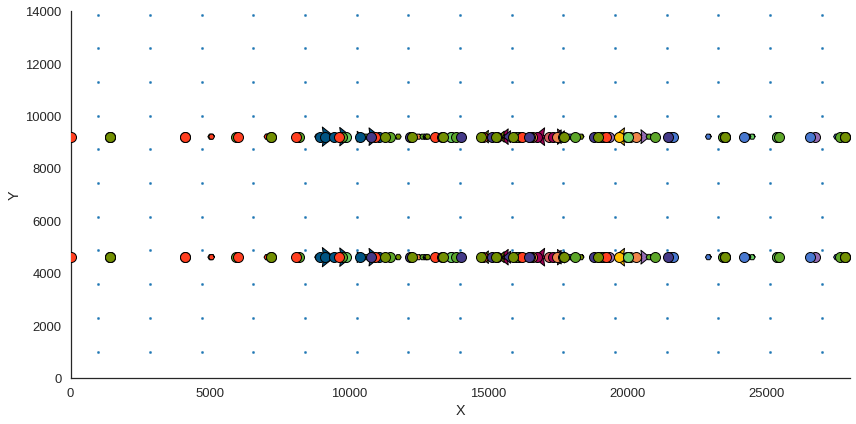

In [14]:
import matplotlib.pyplot as plt
gp._plot.plot_data(geo_model, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:,1], s=5)

In [15]:
geo_model.set_centered_grid(xy_ravel, resolution = [20, 15, 20], radius = 800)

Active grids: ['regular' 'topography' 'centered']


Grid Object. Values: 
array([[  140.        ,   140.        , -6437.5       ],
       [  140.        ,   140.        , -6312.5       ],
       [  140.        ,   140.        , -6187.5       ],
       ...,
       [27800.        , 19800.        , -7139.21428262],
       [27800.        , 19800.        , -7301.36957154],
       [27800.        , 19800.        , -7508.        ]])

In [16]:
geo_model.grid.centered_grid.kernel_centers

array([[ -800.        ,  -800.        ,   -48.        ],
       [ -800.        ,  -800.        ,   -57.6       ],
       [ -800.        ,  -800.        ,   -60.23303986],
       ...,
       [  800.        ,   800.        ,  -639.21428262],
       [  800.        ,   800.        ,  -801.36957154],
       [  800.        ,   800.        , -1008.        ]])

In [94]:
# add densities - from abdelfettah 2014
densities = [0, 0, 0, 0, 0, 2.5, 2.55, 2.55, 
             2.60, 2.57, 2.25, 2.57, 2.67]
geo_model.add_surface_values(densities, ['density'])

,surface,series,order_surfaces,color,id,density
10,Thrust1_south,Thrust1_series,1,#d65f5f,1,0.000000
11,Thrust2_south,Thrust2_series,1,#956cb4,2,0.000000
0,Fault2,Fault2_series,1,#015482,3,0.000000
1,Fault5,Fault5_series,1,#9f0052,4,0.000000
2,Fault6,Fault6_series,1,#ffbe00,5,0.000000
7,Tertiary,Post_tectonic_series,1,#4878d0,6,2.500000
9,Pink,Post_tectonic_series,2,#6acc64,7,2.550000
8,Orange,Post_tectonic_series,3,#ee854a,8,2.550000
6,Mesozoic,Detachement,1,#5DA629,9,2.600000
5,Upper-filling,Syn_tectonic_series2,1,#ff3f20,10,2.570000


In [95]:
gp.set_interpolator(geo_model, output=['gravity'], theano_optimizer='fast_run')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                             values
range                                      32190.8
$C_o$                                  2.46726e+07
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [96]:
sol = gp.compute_model(geo_model)
grav = sol.fw_gravity

/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/core/solution.py:315: UserWarning: Surfaces not computed due to: No surface found at the given iso value.. The surface is: Series: No surface found at the given iso value.; Surface Number:8
  '; Surface Number:' + str(s_n))
/home/bl2/miniconda3/envs/gempy_env/lib/python3.7/site-packages/gempy/core/solution.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.geological_map = np.array([values[0][:, l0: l1], values[4][:, l0: l1].astype(float)])


In [115]:
grav

array([-521.86248815, -534.79092771, -532.27492946, -528.6351437 ,
       -527.96736816, -517.45182871, -521.81225877, -531.08445122,
       -528.95923008, -518.26913751, -513.4178464 , -531.85044651,
       -513.09351997, -524.98666123, -537.4707175 , -529.71777329,
       -532.68704378, -539.12887025, -526.68026728, -522.75915007,
       -531.210219  , -532.25564589, -532.00177487, -530.15197357,
       -530.45199828])

In [113]:
grav1 = grav.reshape(25,1)

In [116]:
station_forw_grav = np.append(station_coordinates, grav1, axis=1)

In [117]:
np.savetxt('../models/20210218_forw_grav.csv', station_forw_grav, fmt='%.5f, %.5f, %')

In [24]:
gp._plot.plot_data(geo_model, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:,1], s=5)
im = plt.imshow(sol.fw_gravity.reshape(grav_res, grav_res), extent = (xy_ravel[:,0].min() + (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,1].min() + (xy_ravel[0, 1] - xy_ravel[30, 1])/2,
                                                       xy_ravel[:,1].max() - (xy_ravel[0, 1] - xy_ravel[30, 1])/2),
           cmap='viridis_r', origin='lower')
plt.colorbar(im)

ValueError: cannot reshape array of size 1 into shape (15,15)

In [28]:
gp.plot_3d(geo_model, show_data=False)

## 3D Plotting

In [20]:
gp.plot_3d(geo_model, show_surfaces=False, show_data=True, show_lith=False,
           image=False, plotter_type='background')

In [21]:
gp.plot_3d(geo_model, plotter_type='background', show_topography=True, show_surfaces=False, show_data=False,
          kwargs_plot_structured_grid={'opacity':1.0}, ve=3)

In [29]:
gp.plot.plot_interactive_3d(geo_model, series=['Graben_series', 'Detachement'], show_topography=True)

IndexError: index 1 is out of bounds for axis 0 with size 1

## Topology

In [22]:
from gempy.assets import topology as tp
# complete model
# edges, centroids = tp.compute_topology(geo_model)
edges, centroids = tp.compute_topology(geo_model, cell_number=5, voxel_threshold=1, direction="y")

In [24]:
fig = plt.figure(figsize=[20,15])
gp._plot.plot_section(geo_model, 5, show_legend=False, show_data=False)
gp.plot.plot_topology(geo_model, edges, centroids, direction="y")

In [14]:
gp.save_model(geo_model,path='../models/20200731_POC_model_3_normal_faults_3D/')

True

## Temperature field

In [6]:
import h5py

In [7]:
T_fid = h5py.File('../models/20200731_SHEMAT_POC_model_3D/heat_conduction_final.h5', mode='r')

In [8]:
x = T_fid['x'][0,0,:]
z = T_fid['z'][:,0,0]
y = T_fid['y'][0,:,0]
units = T_fid['uindex'][:,:,:]
Temperature = T_fid['temp'][:,:,:]

In [9]:
fig = plt.figure(figsize=[15,6])
cs = plt.contourf(x, z-6500, Temperature[:,5,:],32, cmap='rainbow')
plt.contour(x, z-6500, units[:,5,:])
plt.xlabel('X [m]')
plt.ylabel('Depth [m a.s.l.]');
fig.colorbar(cs, label='Temperature [°C]')
fig.tight_layout()

In [86]:
T_fid.keys()

<KeysViewHDF5 ['comp', 'delx', 'dely', 'delz', 'df', 'ec', 'head', 'itemp_bcd', 'itemp_bcn', 'kx', 'ky', 'kz', 'lc', 'lx', 'ly', 'lz', 'por', 'pres', 'q', 'rc', 'rhof', 'temp', 'temp_bcd', 'temp_bcn', 'uindex', 'visf', 'vx', 'vy', 'vz', 'x', 'y', 'z']>

In [91]:
T_fid['lx'][:,:,:].max()

5.401851487160596

In [16]:
fig = plt.figure(figsize=[15,12])
cs = plt.contourf(x, y, Temperature[69,:,:],32, cmap='rainbow')
plt.contour(x, y, units[69,:,:],10)
#plt.contour(x, z-6500, units[:,5,:])
plt.xlabel('X [m]')
plt.ylabel('Y [m]');
fig.colorbar(cs, label='Temperature [°C]')
fig.tight_layout()